## 개체명 인식 모델 제작

In [30]:
import warnings
warnings.filterwarnings(action='ignore')

import time
from random import random

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.layers import Flatten, LSTM, SimpleRNN
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model   # 네트워크 입출력 시각화

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
rc('font', family='Malgun Gothic')
plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

In [31]:
with open('./train_one.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines() # 라인 읽기
    for idx, line in enumerate(lines):
        print(idx, line)

tuple(line.split())        

0 ; 한편, AFC챔피언스리그 E조에 속한 포항 역시 대회 8강 진출이 불투명하다 .

1 $한편, AFC챔피언스리그 <E조:OG>에 속한 포항 역시 대회 8강 진출이 불투명하다 .

2 1	한편	NNG	O

3 1	,	SP	O

4 2	AFC	SL	O

5 2	챔피언스	NNG	O

6 2	리그	NNG	O

7 3	E	SL	B_OG

8 3	조	NNG	I

9 3	에	JKB	O

10 4	속하	VV	O

11 4	ㄴ	ETM	O

12 5	포항	NNP	O

13 6	역시	MAJ	O

14 7	대회	NNG	O

15 8	8강	NNG	O

16 9	진출	NNG	O

17 9	이	JKS	O

18 10	불투명	NNG	O

19 10	하	VV	O

20 10	다	EC	O

21 11	.	SF	O


('11', '.', 'SF', 'O')

In [32]:
sents = []
with open('./train.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines() # 라인 읽기
    for idx, line in enumerate(lines):
        if line[0] == ';' and lines[idx + 1][0] == '$': # 원본 문장
            this_sent = []
        elif line[0] == '$' and lines[idx - 1][0] == ';':
            continue
        elif line[0] == '\n': # 하나의 문장 처리가 종료되는 경우
            sents.append(this_sent) # sents list에 this_sent list 추가
        else:
            # ('11', '.', 'SF', 'O')
            this_sent.append(tuple(line.split())) # 공백을 구분자로 분할하여 tuple로 변경하여 list에 추가

In [33]:
# 학습 파일 불러오기
def read_file(file_name):
    sents = []
    with open(file_name, 'r', encoding='utf-8') as f:
        lines = f.readlines() # 라인 읽기
        for idx, line in enumerate(lines):
            if line[0] == ';' and lines[idx + 1][0] == '$': # 새로운 원본 문장
                # print(line)
                this_sent = []
            elif line[0] == '$' and lines[idx - 1][0] == ';':
                continue
            elif line[0] == '\n': # 하나의 문장 처리가 종료되는 경우
                sents.append(this_sent)
            else:
                this_sent.append(tuple(line.split())) # ('11', '.', 'SF', 'O')

    return sents

In [34]:
# 학습용 말뭉치 데이터를 불러옴
corpus = read_file('./train.txt')
print(type(corpus))
print(corpus[0:2])

<class 'list'>
[[('1', '한편', 'NNG', 'O'), ('1', ',', 'SP', 'O'), ('2', 'AFC', 'SL', 'O'), ('2', '챔피언스', 'NNG', 'O'), ('2', '리그', 'NNG', 'O'), ('3', 'E', 'SL', 'B_OG'), ('3', '조', 'NNG', 'I'), ('3', '에', 'JKB', 'O'), ('4', '속하', 'VV', 'O'), ('4', 'ㄴ', 'ETM', 'O'), ('5', '포항', 'NNP', 'O'), ('6', '역시', 'MAJ', 'O'), ('7', '대회', 'NNG', 'O'), ('8', '8강', 'NNG', 'O'), ('9', '진출', 'NNG', 'O'), ('9', '이', 'JKS', 'O'), ('10', '불투명', 'NNG', 'O'), ('10', '하', 'VV', 'O'), ('10', '다', 'EC', 'O'), ('11', '.', 'SF', 'O')], [('1', '2003', 'SN', 'B_DT'), ('1', '년', 'NNB', 'I'), ('2', '6', 'SN', 'I'), ('2', '월', 'NNB', 'I'), ('3', '14', 'SN', 'I'), ('3', '일', 'NNB', 'I'), ('4', '사직', 'NNG', 'O'), ('5', '두산', 'NNP', 'O'), ('5', '전', 'NNG', 'O'), ('6', '이후', 'NNG', 'O'), ('7', '박명환', 'NNP', 'B_PS'), ('7', '에게', 'JKB', 'O'), ('8', '당하', 'VV', 'O'), ('8', '았', 'EP', 'O'), ('8', '던', 'ETM', 'O'), ('9', '10', 'SN', 'O'), ('9', '연패', 'NNG', 'O'), ('10', '사슬', 'NNG', 'O'), ('10', '을', 'JKO', 'O'), ('11', '거의', '

In [35]:
# 말뭉치 데이터에서 단어와 BIO 태그만 불러와 학습용 데이터셋 생성
sentences, tags = [], []
# t=[('1', '한편', 'NNG', 'O'), ('1', ',', 'SP', 'O'), ('2', 'AFC', 'SL', 'O'), ('2', '챔피언스', 'NNG', 'O'), ('2', '리그', 'NNG', 'O'), ('3', 'E', 'SL', 'B_OG'), ('3', '조', 'NNG', 'I'), ('3', '에', 'JKB', 'O'), ('4', '속하', 'VV', 'O'), ('4', 'ㄴ', 'ETM', 'O'), ('5', '포항', 'NNP', 'O'), ('6', '역시', 'MAJ', 'O'), ('7', '대회', 'NNG', 'O'), ('8', '8강', 'NNG', 'O'), ('9', '진출', 'NNG', 'O'), ('9', '이', 'JKS', 'O'), ('10', '불투명', 'NNG', 'O'), ('10', '하', 'VV', 'O'), ('10', '다', 'EC', 'O'), ('11', '.', 'SF', 'O')]
for t in corpus: # 2차원 list임으로 list가 1개씩 추출되어 t 변수에 할당
    tagged_sentence = []
    sentence, bio_tag = [], []
    for w in t: # list안의 구성요소는 tuple의 배열임으로 1개씩 추출, ('1', '한편', 'NNG', 'O')
        tagged_sentence.append((w[1], w[3])) # ('한편', 'O')
        sentence.append(w[1]) # '한편'
        bio_tag.append(w[3])  # 'O'

    sentences.append(sentence) # 하나의 문장이 처리되고 단어만 저장
    tags.append(bio_tag)       # 하나의 문장이 처리되고 BIO만 저장

In [36]:
print("샘플 크기 : \n", len(sentences))
print("0번째 샘플 문장 시퀀스 : \n", sentences[0])
print("0번째 샘플 bio 태그 : \n", tags[0])
print("샘플 문장 시퀀스 최대 길이 :", max(len(l) for l in sentences))
# map(len, sentences): sentences list에 len 함수를 실행(대응)시켜라
print("샘플 문장 시퀀스 평균 길이 :", (sum(map(len, sentences))/len(sentences)))

샘플 크기 : 
 3555
0번째 샘플 문장 시퀀스 : 
 ['한편', ',', 'AFC', '챔피언스', '리그', 'E', '조', '에', '속하', 'ㄴ', '포항', '역시', '대회', '8강', '진출', '이', '불투명', '하', '다', '.']
0번째 샘플 bio 태그 : 
 ['O', 'O', 'O', 'O', 'O', 'B_OG', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
샘플 문장 시퀀스 최대 길이 : 168
샘플 문장 시퀀스 평균 길이 : 34.03909985935302


In [37]:
# 토크나이저 정의, 수치화
# 첫 번째 인덱스에는 OOV 사용: Out Of Vocabulary, 단어 사전에 없는 단어임.
sent_tokenizer = preprocessing.text.Tokenizer(oov_token='OOV') 
sent_tokenizer.fit_on_texts(sentences)    # 토큰을 빈도수 기준으로 단어 집합 생성
print(sent_tokenizer.word_counts.items()) # 토큰의 빈도수 출력

odict_items([('한편', 63), (',', 1650), ('afc', 2), ('챔피언스', 15), ('리그', 69), ('e', 14), ('조', 32), ('에', 1963), ('속하', 4), ('ㄴ', 2550), ('포항', 8), ('역시', 22), ('대회', 79), ('8강', 9), ('진출', 31), ('이', 3163), ('불투명', 1), ('하', 4222), ('다', 2517), ('.', 3629), ('2003', 6), ('년', 386), ('6', 170), ('월', 349), ('14', 51), ('일', 855), ('사직', 4), ('두산', 30), ('전', 199), ('이후', 57), ('박명환', 2), ('에게', 137), ('당하', 26), ('았', 1359), ('던', 204), ('10', 191), ('연패', 18), ('사슬', 1), ('을', 2713), ('거의', 8), ('5', 255), ('만', 343), ('끊', 3), ('는', 2560), ('의미', 14), ('있', 875), ('승리', 44), ('었', 1071), ('ap', 3), ('통신', 25), ('은', 1482), ('8', 130), ('(', 1084), ('이하', 39), ('한국', 168), ('시간', 85), (')', 1081), ('올라주원', 1), ('유잉', 1), ('비롯', 26), ('아', 1012), ('애드리언', 1), ('댄틀리', 1), ('팻', 1), ('라일리', 1), ('감독', 117), ('캐시', 2), ('러시', 1), ('tv', 39), ('해설가', 1), ('딕', 1), ('바이텔', 1), ('디트로이트', 5), ('피스톤스', 1), ('의', 1972), ('구단주', 2), ('윌리엄', 2), ('데이비드슨', 1), ('등', 455), ('2008', 63), ('명예', 12), (

In [38]:
tag_tokenizer = preprocessing.text.Tokenizer(lower=False) # 태그 정보는 lower= False 소문자로 변환하지 않는다.
tag_tokenizer.fit_on_texts(tags) # 토큰을 빈도수 기준으로 단어 집합 생성

print(tag_tokenizer.word_counts.items()) # 큰의 빈도수 출력

odict_items([('O', 103673), ('B_OG', 3267), ('I', 7130), ('B_DT', 2135), ('B_PS', 2347), ('B_LC', 2125), ('B_TI', 332)])


In [39]:
# 단어 사전 및 태그 사전 크기
vocab_size = len(sent_tokenizer.word_index) + 1 # +1: OOV
tag_size = len(tag_tokenizer.word_index) + 1
print("BIO 태그 사전 크기 :", tag_size)
print("단어 사전 크기 :", vocab_size)

BIO 태그 사전 크기 : 8
단어 사전 크기 : 13834


In [40]:
# texts_to_sequences(corpus): 토큰에 할당된 번호를 기준으로 문장을 시퀀스 번호로 변환
x_train = sent_tokenizer.texts_to_sequences(sentences) # 매핑, 토큰을 시퀀스 번호로 변환
y_train = tag_tokenizer.texts_to_sequences(tags)       # 매핑, 토큰을 시퀀스 번호로 변환
print(x_train[0])
print(y_train[0])

[183, 11, 4276, 884, 162, 931, 402, 10, 2608, 7, 1516, 608, 145, 1361, 414, 4, 6347, 2, 8, 3]
[1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [41]:
# index to word / index to NER 정의
index_to_word = sent_tokenizer.index_word # 시퀀스 인덱스를 단어로 변환하기 위해 사용
print(index_to_word)

{1: 'OOV', 2: '하', 3: '.', 4: '이', 5: '을', 6: '는', 7: 'ㄴ', 8: '다', 9: '의', 10: '에', 11: ',', 12: '를', 13: '은', 14: '았', 15: '고', 16: '(', 17: ')', 18: '었', 19: '가', 20: '아', 21: '에서', 22: '으로', 23: '있', 24: '일', 25: '되', 26: '로', 27: "'", 28: '어', 29: 'ㄹ', 30: '과', 31: '들', 32: '1', 33: '2', 34: '도', 35: '와', 36: '-', 37: '등', 38: '것', 39: '지', 40: '3', 41: 'ㄴ다', 42: '년', 43: '"', 44: '월', 45: '%', 46: '만', 47: '적', 48: '기', 49: '게', 50: '4', 51: '시', 52: '원', 53: '며', 54: '수', 55: '5', 56: '밝히', 57: '대하', 58: '주', 59: '말', 60: '다고', 61: '면', 62: '던', 63: '위하', 64: '전', 65: '오', 66: '까지', 67: '10', 68: '대', 69: '지나', 70: '부터', 71: '7', 72: ':', 73: '6', 74: '한국', 75: '받', 76: '않', 77: '명', 78: '경기', 79: '대표', 80: '보', 81: '지만', 82: '라고', 83: '시장', 84: '에게', 85: '따르', 86: '9', 87: '8', 88: '개', 89: '내', 90: '중', 91: '서울', 92: '‘', 93: '분', 94: '억', 95: '회', 96: '’', 97: '감독', 98: '의원', 99: '기록', 100: '제', 101: '~', 102: '11', 103: '습니다', 104: '팀', 105: '그', 106: 'ㄴ다고', 107: '이번', 108: '

In [42]:
# index to word / index to NER 정의
index_to_ner = tag_tokenizer.index_word   # 시퀀스 인덱스를 NER로 변환하기 위해 사용
index_to_ner[0] = 'PAD' # 단어가 부족한 경우 입력 차원을 맞추기위한 기본 값 정의
print(index_to_ner)

{1: 'O', 2: 'I', 3: 'B_OG', 4: 'B_PS', 5: 'B_DT', 6: 'B_LC', 7: 'B_TI', 0: 'PAD'}


In [43]:
# 시퀀스 패딩 처리, 입력 차원은 같아야함.
max_len = 40 # 샘플 문장 시퀀스 평균 길이 : 34.03909985935302 참고
x_train = preprocessing.sequence.pad_sequences(x_train, padding='post', maxlen=max_len)
y_train = preprocessing.sequence.pad_sequences(y_train, padding='post', maxlen=max_len)

In [44]:
print(x_train[0])
print(y_train[0]) # {1: 'O', 2: 'I', 3: 'B_OG', 4: 'B_PS', 5: 'B_DT', 6: 'B_LC', 7: 'B_TI', 0: 'PAD'}

[ 183   11 4276  884  162  931  402   10 2608    7 1516  608  145 1361
  414    4 6347    2    8    3    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[1 1 1 1 1 3 2 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


In [45]:
print(x_train[1])
print(y_train[2]) # {1: 'O', 2: 'I', 3: 'B_OG', 4: 'B_PS', 5: 'B_DT', 6: 'B_LC', 7: 'B_TI', 0: 'PAD'}

[1910   42   73   44  231   24 2609  430   64  206 4277   84  513   14
   62   67  748 6348    5 1517   55   42   46   10 3252    6  932   23
    6  275    4   18    8    3    0    0    0    0    0    0]
[2 1 4 2 1 1 4 2 1 1 1 1 4 2 1 3 2 1 1 4 2 1 1 5 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


In [46]:
# 학습 데이터와 테스트 데이터를 8:2 비율로 분리
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=.2, random_state=0)

In [47]:
# 출력 데이터를 원-핫 인코딩, 연속실행 안됨.
y_train = tf.keras.utils.to_categorical(y_train, num_classes=tag_size)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=tag_size)

In [48]:
print("학습 샘플 시퀀스 형상 : ", x_train.shape)
print("학습 샘플 레이블 형상 : ", y_train.shape)
print("테스트 샘플 시퀀스 형상 : ", x_test.shape)
print("테스트 샘플 레이블 형상 : ", y_test.shape)

학습 샘플 시퀀스 형상 :  (2844, 40)
학습 샘플 레이블 형상 :  (2844, 40, 8)
테스트 샘플 시퀀스 형상 :  (711, 40)
테스트 샘플 레이블 형상 :  (711, 40, 8)


In [49]:
print(x_train[0]) # 문장
print(y_train[0]) # 태그
# [ 430 4417   16  416   17    9 6582   13 6583    2   14    8    3    0
#     0    0    0    0    0    0    0    0    0    0    0    0    0    0
#     0    0    0    0    0    0    0    0    0    0    0    0]
# [[0. 0. 0. 1. 0. 0. 0. 0.]
#  [0. 0. 0. 0. 1. 0. 0. 0.]
#  [0. 1. 0. 0. 0. 0. 0. 0.]
#  [0. 1. 0. 0. 0. 0. 0. 0.]
#  [0. 1. 0. 0. 0. 0. 0. 0.]
#  [0. 1. 0. 0. 0. 0. 0. 0.]....

[ 430 4417   16  416   17    9 6582   13 6583    2   14    8    3    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0.

In [50]:
print('출력 갯수:', tag_size)

출력 갯수: 8


In [51]:
# 모델 정의(Bi-LSTM)
# TimeDistributed: LSTM이 many-to-many로 동작됨
model = Sequential()
# input_dim=vocab_size: 단어 사전의 크기
# output_dim=30: 임베딩한 후의 벡터의 크기
# input_length=max_len: 입력 시퀀스의 길이
# mask_zero=True: 0으로 패딩된 값을 마스킹하여 네트워크의 뒤로 전달되지 않게 만든다. 
# 이렇게 하면 인위적으로 패딩된 부분은 학습에 영향을 미치지 않는다.
model.add(Embedding(input_dim=vocab_size, output_dim=30, input_length=max_len, mask_zero=True))
# 200: 뉴런수
# return_sequences=True: 양방향 LSTM에서는 필수로 True
# dropout=0.50: 입력 데이터 Dropout 50%
# recurrent_dropout=0.25: 순환시 dropout
model.add(Bidirectional(LSTM(200, return_sequences=True, dropout=0.50, recurrent_dropout=0.25)))
# Dense가 3차원 데이터를 받을 수 있도록 처리함.
model.add(TimeDistributed(Dense(8, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

start = time.time()
hist=model.fit(x_train, y_train, validation_split=0.3, shuffle=True, batch_size=128, epochs=20, callbacks=[es])
print('time:', time.time() - start) # i5 2320 134
print("평가 결과 : ", model.evaluate(x_test, y_test)[1])

Epoch 1/20
16/16 [==============================] - 23s 971ms/step - loss: 0.7995 - accuracy: 0.7104 - val_loss: 0.3948 - val_accuracy: 0.8687
Epoch 2/20
16/16 [==============================] - 14s 887ms/step - loss: 0.3605 - accuracy: 0.8681 - val_loss: 0.2820 - val_accuracy: 0.8868
Epoch 3/20
16/16 [==============================] - 14s 876ms/step - loss: 0.1997 - accuracy: 0.9043 - val_loss: 0.2407 - val_accuracy: 0.9057
Epoch 4/20
16/16 [==============================] - 14s 869ms/step - loss: 0.1442 - accuracy: 0.9286 - val_loss: 0.2231 - val_accuracy: 0.9114
Epoch 5/20
16/16 [==============================] - 14s 880ms/step - loss: 0.1059 - accuracy: 0.9481 - val_loss: 0.2261 - val_accuracy: 0.9178
Epoch 6/20
16/16 [==============================] - 14s 897ms/step - loss: 0.0876 - accuracy: 0.9581 - val_loss: 0.2316 - val_accuracy: 0.9198
time: 93.16576266288757
23/23 [==============================] - 1s 52ms/step - loss: 0.2007 - accuracy: 0.9141
평가 결과 :  0.9141285419464111


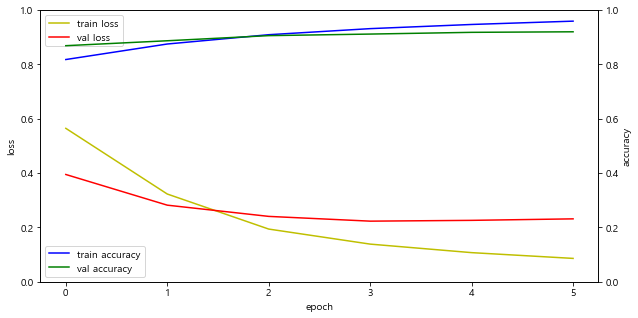

In [52]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()   # 오른쪽 y 축 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1]) # 0.0, 1: 0 ~ 100 %, 정확도임으로 변경하지 않음

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [53]:
print(x_test.shape)
print(x_test[0])

(711, 40)
[  69    7 1407   42 7891  581  206 2409   19 1560 4932    2   15  604
   66 2047   25   28 7892  344   13  271    5  358    4  121    8    3
    0    0    0    0    0    0    0    0    0    0    0    0]


In [54]:
# 시퀀스를 NER 태그로 변환 테스트
y_predicted = model.predict(x_test) # (711, 40) => model => (711, 40, 8)
print(y_predicted.shape) # (711, 40, 8)
# print(y_predicted[0])
sequence = y_predicted[0]
print('-> type(sequence):', type(sequence))
print('-> sequence.shape:', sequence.shape)
print('-> sequence:', sequence)

(711, 40, 8)
-> type(sequence): <class 'numpy.ndarray'>
-> sequence.shape: (40, 8)
-> sequence: [[1.69067015e-03 1.01336802e-03 1.83771089e-01 2.01909602e-01
  3.04835793e-02 3.66608471e-01 1.38266161e-01 7.62570798e-02]
 [2.48431257e-04 3.58640969e-01 6.26731277e-01 4.45931684e-03
  3.13898479e-03 2.27884878e-03 2.33565038e-03 2.16643349e-03]
 [2.24889169e-04 6.84733510e-01 2.70469368e-01 1.31145436e-02
  2.96189589e-03 2.21576970e-02 2.56118132e-03 3.77695751e-03]
 [5.43085480e-05 7.94083928e-04 9.02076900e-01 4.63843020e-03
  9.25920962e-04 5.95063046e-02 9.05674789e-03 2.29473636e-02]
 [4.43112920e-04 1.99605614e-01 5.13321459e-01 1.24541536e-01
  3.82804647e-02 4.09126189e-03 9.76221338e-02 2.20943522e-02]
 [9.94448565e-05 3.13884556e-01 6.53538883e-01 9.64990817e-03
  7.08071422e-03 9.25447152e-04 1.08398842e-02 3.98116419e-03]
 [8.84287601e-06 8.45438421e-01 1.52793258e-01 5.40363719e-04
  6.27854432e-04 4.01152356e-05 4.10690700e-04 1.40394070e-04]
 [5.61048910e-06 9.89197552e-

In [57]:
result = []
temp = []
for pred in sequence:
    pred_index = np.argmax(pred) # 어떤 BIO 태그에 속하는지 검색
    print('-> pred_index:', pred_index)
    # index_to_ner: {1: 'O', 2: 'I', 3: 'B_OG', 4: 'B_PS', 5: 'B_DT', 6: 'B_LC', 7: 'B_TI', 0: 'PAD'}
    print('-> NER:', index_to_ner[pred_index])
    temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 차원을 맞추기위한 'PAD'sms 0으로 변경
    
result.append(temp)
print('-> temp:', temp)

-> pred_index: 5
-> NER: B_DT
-> pred_index: 2
-> NER: I
-> pred_index: 1
-> NER: O
-> pred_index: 2
-> NER: I
-> pred_index: 2
-> NER: I
-> pred_index: 2
-> NER: I
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: O
-> pred_index: 1
-> NER: 

In [ ]:
# 위의 코드를 함수로 통합

In [58]:
# 시퀀스를 NER 태그로 변환하는 함수
def sequences_to_tag(sequences):
    result = []
    for sequence in sequences:
        temp = []
        for pred in sequence:
            pred_index = np.argmax(pred)
            temp.append(index_to_ner[pred_index].replace("PAD", "O"))
        result.append(temp)
    return result

In [59]:
# 테스트 데이터셋의 NER 예측
y_predicted = model.predict(x_test) # (711, 40) => model => (711, 40, 8)

In [60]:
pred_tags = sequences_to_tag(y_predicted) # 예측된 NER
print(pred_tags[0])
test_tags = sequences_to_tag(y_test) # 실제 NER
print(test_tags[0])

['B_DT', 'I', 'O', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['B_DT', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [61]:
# F1 스코어 계산을 위해 사용
from seqeval.metrics import f1_score, classification_report
print(classification_report(test_tags, pred_tags))
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

              precision    recall  f1-score   support

           _       0.48      0.43      0.45       657
         _DT       0.83      0.72      0.77       335
         _LC       0.39      0.16      0.22       312
         _OG       0.43      0.42      0.43       481
         _PS       0.37      0.13      0.19       374
         _TI       1.00      0.03      0.06        66

   micro avg       0.51      0.37      0.43      2225
   macro avg       0.58      0.31      0.35      2225
weighted avg       0.51      0.37      0.41      2225

F1-score: 43.0%


In [62]:
sent_tokenizer.word_index # 단어의 번호, '삼성전자': 531,

{'OOV': 1,
 '하': 2,
 '.': 3,
 '이': 4,
 '을': 5,
 '는': 6,
 'ㄴ': 7,
 '다': 8,
 '의': 9,
 '에': 10,
 ',': 11,
 '를': 12,
 '은': 13,
 '았': 14,
 '고': 15,
 '(': 16,
 ')': 17,
 '었': 18,
 '가': 19,
 '아': 20,
 '에서': 21,
 '으로': 22,
 '있': 23,
 '일': 24,
 '되': 25,
 '로': 26,
 "'": 27,
 '어': 28,
 'ㄹ': 29,
 '과': 30,
 '들': 31,
 '1': 32,
 '2': 33,
 '도': 34,
 '와': 35,
 '-': 36,
 '등': 37,
 '것': 38,
 '지': 39,
 '3': 40,
 'ㄴ다': 41,
 '년': 42,
 '"': 43,
 '월': 44,
 '%': 45,
 '만': 46,
 '적': 47,
 '기': 48,
 '게': 49,
 '4': 50,
 '시': 51,
 '원': 52,
 '며': 53,
 '수': 54,
 '5': 55,
 '밝히': 56,
 '대하': 57,
 '주': 58,
 '말': 59,
 '다고': 60,
 '면': 61,
 '던': 62,
 '위하': 63,
 '전': 64,
 '오': 65,
 '까지': 66,
 '10': 67,
 '대': 68,
 '지나': 69,
 '부터': 70,
 '7': 71,
 ':': 72,
 '6': 73,
 '한국': 74,
 '받': 75,
 '않': 76,
 '명': 77,
 '경기': 78,
 '대표': 79,
 '보': 80,
 '지만': 81,
 '라고': 82,
 '시장': 83,
 '에게': 84,
 '따르': 85,
 '9': 86,
 '8': 87,
 '개': 88,
 '내': 89,
 '중': 90,
 '서울': 91,
 '‘': 92,
 '분': 93,
 '억': 94,
 '회': 95,
 '’': 96,
 '감독': 97,
 '의원': 98,
 '기록'

In [63]:
# 새로운 유형의 문장 NER 예측
word_to_index = sent_tokenizer.word_index
new_sentence = '삼성전자 출시 스마트폰 오늘 애플 도전장 내밀다.'.split()
print(word_to_index.get('삼성전자')) # 531
print(word_to_index.get('삼성전자', 1)) # 531

531
531


In [67]:
# 새로운 유형의 문장 NER 예측
word_to_index = sent_tokenizer.word_index
new_sentence = '삼성전자 출시 스마트폰 오늘 애플 도전장 내밀다.'.split()
new_x = []
for w in new_sentence:
    try:
        new_x.append(word_to_index.get(w, 1)) # 단어의 index 찾아 추가
    except KeyError:
        # 모르는 단어의 경우 OOV
        new_x.append(word_to_index['OOV'])  # index 가 없는 단어는 OOV 추가

print("새로운 유형의 시퀀스 : ", new_x)
new_padded_seqs = preprocessing.sequence.pad_sequences([new_x], padding="post", value=0, maxlen=max_len)
print(max_len)
print(new_padded_seqs)

새로운 유형의 시퀀스 :  [531, 307, 1476, 286, 1507, 6766, 1]
40
[[ 531  307 1476  286 1507 6766    1    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]


In [68]:
x = np.array([[4, 2, 3], [2, 0, 1], [5, 6, 2]])
print(x)
print('axis=0:', np.argmax(x, axis=0))   # 행기준,여러행에서의 최대값 index
print('axis=1:', np.argmax(x, axis=1))   # 열기준, 하나의 행안에서의 최대값 index
print('axis=-1:', np.argmax(x, axis=-1)) # axis=-1과 동일

[[4 2 3]
 [2 0 1]
 [5 6 2]]
axis=0: [2 2 0]
axis=1: [0 0 1]
axis=-1: [0 0 1]


In [69]:
x = np.array([[[4, 2, 3], [2, 0, 1], [5, 6, 2]]])
print(x)
print('axis=0:', np.argmax(x, axis=0))   # 모두 0
print('axis=1:', np.argmax(x, axis=1))   # 2차원배열의 axis=0과 동일
print('axis=-1:', np.argmax(x, axis=-1)) # 2차원배열의 axis=1과 동일, 행별 행안에서 가장 큰 값의 index

[[[4 2 3]
  [2 0 1]
  [5 6 2]]]
axis=0: [[0 0 0]
 [0 0 0]
 [0 0 0]]
axis=1: [[2 2 0]]
axis=-1: [[0 0 1]]


In [70]:
# NER 예측
p = model.predict(np.array([new_padded_seqs[0]]))
# print('-> p:', p)
# axis=-1: 2차원배열의 axis=1과 동일, 행별 행안에서 가장 큰 값의 index
p = np.argmax(p, axis=-1) # 예측된 NER 인덱스값 추출
print("{:10} {:5}".format("단어", "예측된 NER"))
print("-" * 50)

for w, pred in zip(new_sentence, p[0]):
    print("{:10} {:5}".format(w, index_to_ner[pred]))

단어         예측된 NER
--------------------------------------------------
삼성전자       B_OG 
출시         O    
스마트폰       O    
오늘         B_DT 
애플         I    
도전장        I    
내밀다.       I    
